# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, data are batch corrected and normalised.

We filtered cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Pre-processing and filtering
2. Preparation of Batch effect correction
3. Batch effect correction with adjusted Combat
4. Cell type annotation (control only) 
    * ISC subtype annotation
    * Goblet, Paneth, Tuft cell subtype annotation
    * EEC subtype annotation
5. Cell type data analysis with Graph abstraction (control only)
6. Pseudotime analysis of ISC-PC lineage
7. Differential expression analysis of Mutant and Control cells

This notebook covers **part 5** and **part 6**.

It must be noted that all differential expression tests are carried out in R using the package limma and are therefore not included in the notebook structure.

# Initialise scanpy

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import scanpy.api as sc
import matplotlib as mpl
import anndata as ann
#import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy as sci
import os

sc.settings.verbosity = 3                # amount of output
#sc.settings.set_dpi(60) # deprecated. low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-02-08 16:55.


In [18]:
sc.settings.figdir ='./../figures/'

In [2]:
import datetime

now = datetime.datetime.now()

In [3]:
today = now.strftime("%y%m%d")

## Load extensions

In [4]:
%run '~/Documents/Python/maren_codes/bar_frequency.py'
%run '~/Documents/Python/maren_codes/cal_density.py'
%run '~/Documents/Python/maren_codes/genes_to_xls.py'

Set custom color bar.

In [5]:
colors2 = pl.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = pl.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Custom dotplot

In [209]:
from scanpy import settings
from scanpy import logging as logg
from scanpy.plotting import *
#from scanpy..utils import sanitize_anndata
from pandas.api.types import is_categorical_dtype

def sanitize_anndata(adata):
    adata._sanitize()

def _prepare_dataframe(adata, var_names, groupby=None, 
                       use_raw=None, log=False, num_categories=7):
    """
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
    sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def pos_mean(group):
    return group[group>0].mean()

def dotplot(adata, var_names, groupby=None, use_raw=None, 
            log=False, num_categories=7, max_scale=None, min_scale=None,
            color_map='Reds', figsize=None, 
            var_group_positions=None, var_group_labels=None,
            var_group_rotation=None, show=None, save=None, **kwds):
    """\
    Makes a _dot plot_ of the expression values of `var_names`.
    For each var_name and each `groupby` category a dot is plotted. Each dot
    represents two values: mean expression within each category (visualized by
    color) and fraction of cells expressing the var_name in the
    category. (visualized by the size of the dot).  If groupby is not given, the
    dotplot assumes that all data belongs to a single category. A gene is not
    considered expressed if the expression value in the adata (or adata.raw) is
    equal to zero.
    For instance, for each marker gene, the mean value and the percentage of cells
    expressing the gene can be visualized for each cluster.
    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        var_names should be a valid subset of  `.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that groupby is
        a categorical. If groupby is not a categorical observation, it would be
        subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value determines
        the number of groups into which the groupby observation should be subdivided.
    max_scale : `float` (default: `None`) - enable global color scaling if not `None`
    min_scale : `float` (default: `None`) - enable global color scaling if not `None`
    color_map : `str`, optional (default: `Reds`)
        String denoting matplotlib color map.
    figsize : (float, float), optional (default: None)
        Figure size (width, height. If not set, the figure width is set based on the
        number of  `var_names` and the height is set to 10.
    var_group_positions :  list of `tuples`.
        Use this parameter to highlight groups of `var_names`. This will draw a 'bracket'
        on top of the plot between the given start and end positions. If the
        parameter `var_group_labels` is set, the corresponding labels is added on
        top of the bracket. E.g. var_group_positions = [(4,10)] will add a bracket
        between the fourth var_name and the tenth var_name. By giving more
        positions, more brackets are drawn.
    var_group_labels : list of `str`
        Labels for each of the var_group_positions that want to be highlighted.
    var_group_rotation : `float` (default: `None`)
        Label rotation degrees. By default, labels larger than 4 characters are rotated 90 degrees
    {show_save_ax}
    **kwds : keyword arguments
        Are passed to `matplotlib.pyplot.scatter`.
    Returns
    -------
    A list of `matplotlib.Axes` where the first ax is the groupby categories colorcode, the
    second axis is the heatmap and the third axis is the colorbar.
    """
    
    if use_raw is None and adata.raw is not None: use_raw = True
    categories, obs_tidy = _prepare_dataframe(adata, var_names, 
                                    groupby, use_raw, log, num_categories)

    # for if category defined by groupby (if any) compute for each var_name
    # 1. the mean value over the category
    # 2. the fraction of cells in the category having a value > 0

    # 1. compute mean value
    mean_obs = obs_tidy.groupby(level=0).apply(pos_mean)

    # 2. compute fraction of cells having value >0
    # transform obs_tidy into boolean matrix
    obs_bool = obs_tidy.astype(bool)

    # compute the sum per group which in the boolean matrix this is the number
    # of values >0, and divide the result by the total number of values in the group
    # (given by `count()`)
    fraction_obs = obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()

    if figsize is None:
        height = len(categories) * 0.3 + 1  # +1 for labels
        # if the number of categories is small (eg 1 or 2) use
        # a larger height
        height = max([1.5, height])
        heatmap_width = len(var_names) * 0.5
        width = heatmap_width + 1.6 + 1  
        # +1.6 to account for the colorbar and  + 1 to account for labels
    else:
        width, height = figsize
        heatmap_width = width * 0.75

    # colorbar ax width should not change with differences 
    #in the width of the image
    # otherwise can become too small
    colorbar_width = 0.4
    colorbar_width_spacer = 0.7
    size_legend_width = 0.5

    if var_group_positions is not None and len(var_group_positions) > 0:
        # add some space in case 'brackets' want to be plotted on top of the image
        height_ratios = [0.5, 10]
    else:
        height_ratios = [0, 10.5]

    # define a layout of 2 rows x 4 columns
    # first row is for 'brackets' (if no brackets needed, 
    #the height of this row is zero)
    # second row is for main content. This second row
    # is divided into 4 axes:
    #   first ax is for the main figure
    #   second ax is for the color bar legend
    #   third ax is for an spacer that avoids the ticks
    #    from the color bar to be hidden beneath the size lengend axis
    #   fourth ax is to plot the size legend
    from matplotlib import gridspec
    fig = pl.figure(figsize=(width, height))
    axs = gridspec.GridSpec(nrows=2, ncols=4, left=0.05, 
                            right=0.48, wspace=0.05, hspace=0.04,
                            width_ratios=[heatmap_width, 
                                    colorbar_width, 
                                          colorbar_width_spacer, 
                                          size_legend_width],
                            height_ratios=height_ratios)
    if len(categories) < 4:
        # when few categories are shown, the colorbar and size legend
        # need to be larger than the main plot, otherwise they would look
        # compressed. For this, the dotplot ax is split into two:
        axs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axs[1, 0],
                                    height_ratios=[len(categories) * 0.3, 1])
        dot_ax = fig.add_subplot(axs2[0])
    else:
        dot_ax = fig.add_subplot(axs[1, 0])

    color_legend = fig.add_subplot(axs[1, 1])

    # to keep the size_legen of about the same height, irrespective
    # of the number of categories, the fourth ax is subdivided into two parts
    size_legend_height = min(1.3, height)
    # wspace is proportional to the width but a constant value is
    # needed such that the spacing is the same for thinner or wider images.
    wspace = 10.5 / width
    axs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axs[1, 3], 
                                            wspace=wspace,
                                    height_ratios=[size_legend_height / height,
                                    (height - size_legend_height) / height])
    size_legend = fig.add_subplot(axs3[0])

    # make scatter plot in which
    # x = var_names
    # y = groupby category
    # size = fraction
    # color = mean expression

    y, x = np.indices(mean_obs.shape)
    y = y.flatten()
    x = x.flatten()
    frac = fraction_obs.values.flatten()
    mean_flat = mean_obs.values.flatten()
    cmap = pl.get_cmap(color_map)

    size = (frac * 10) ** 2

    import matplotlib.colors
    if max_scale is None:
        max_scale = max(mean_flat)
        
    if min_scale is None:
        min_scale = max(0,min(mean_flat))
    
    normalize = matplotlib.colors.Normalize(vmax=max_scale, vmin=min_scale)
    colors = [cmap(normalize(value)) for value in mean_flat]
    
    dot_ax.scatter(x, y, color=colors, s=size, cmap=cmap, 
                   norm=None, edgecolor='none', **kwds)
    y_ticks = range(mean_obs.shape[0])
    dot_ax.set_yticks(y_ticks)
    dot_ax.set_yticklabels([mean_obs.index[idx] for idx in y_ticks])

    x_ticks = range(mean_obs.shape[1])
    dot_ax.set_xticks(x_ticks)
    dot_ax.set_xticklabels([mean_obs.columns[idx] for idx in x_ticks], 
                           rotation=90)
    dot_ax.tick_params(axis='both', labelsize='small')
    dot_ax.grid(False)
    dot_ax.set_xlim(-0.5, len(var_names) + 0.5)
    dot_ax.set_ylabel(groupby)

    # to be consistent with the heatmap plot, is better to
    # invert the order of the y-axis, such that the first group is on
    # top
    ymin, ymax = dot_ax.get_ylim()
    dot_ax.set_ylim(ymax+0.5, ymin - 0.5)

    dot_ax.set_xlim(-1, len(var_names) + 0.5)

    # plot group legends on top of dot_ax (if given)
    if var_group_positions is not None and len(var_group_positions) > 0:
        gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
        _plot_gene_groups_brackets(gene_groups_ax, 
                                   group_positions=var_group_positions,
                                   group_labels=var_group_labels,
                                   rotation=var_group_rotation)

    # plot colorbar
    import matplotlib.colorbar
    matplotlib.colorbar.ColorbarBase(color_legend, cmap=cmap, norm=normalize)

    # plot size bar
    fracs_legend = np.array([0.25, 0.50, 0.75, 1])
    size = (fracs_legend * 10) ** 2
    color = [cmap(normalize(value)) for value in np.repeat(max(mean_flat) * 0.7, len(size))]
    size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, color=color)
    size_legend.set_yticks(range(len(size)))
    size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legend])

    size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)

    # remove x ticks and labels
    size_legend.tick_params(axis='x', bottom=False, labelbottom=False)

    # remove surrounding lines
    size_legend.spines['right'].set_visible(False)
    size_legend.spines['top'].set_visible(False)
    size_legend.spines['left'].set_visible(False)
    size_legend.spines['bottom'].set_visible(False)
    size_legend.grid(False)

    ymin, ymax = size_legend.get_ylim()
    size_legend.set_ylim(ymin, ymax+0.5)

    utils.savefig_or_show('dotplot', show=show, save=save)
    return axs

# Load data

In [7]:
alin = sc.read('./../data/gut_AB_AL_log_cor_control_anno.h5ad')

In [8]:
alin

AnnData object with n_obs × n_vars = 56240 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase', 'louvain', 'cell_type', 'ISC_score', 'EEC_score', 'Enterocyte_score', 'PC_score', 'GC_score', 'Tuft_score', 'refined_clustering', 'major_cell_type', 'proma_cell_type'
    var: 'mean', 'dispersion'
    uns: 'cell_type_colors', 'louvain', 'louvain_colors', 'major_cell_type_colors', 'neighbors', 'paga', 'pca', 'phase_colors', 'proma_cell_type_colors', 'rank_genes_groups', 'refined_clustering_colors', 'refined_clustering_sizes', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [9]:
pd.value_counts(alin.obs['proma_cell_type'])

Paneth cell              15471
Enterocyte progenitor    10705
ISC                      10560
Enterocyte                5857
Goblet cell               4335
EEC                       1821
Goblet progenitor         1512
early Goblet              1511
Paneth progenitor         1325
Tuft cell                 1271
EE progenitor             1052
Tuft progenitor            820
Name: proma_cell_type, dtype: int64

# Visualisation

First, we define a color scheme for the progenitor and mature cell type populations.

Let us reorder the populations.

In [12]:
alin.obs['proma_cell_type'] = alin.obs['proma_cell_type'].cat.reorder_categories(['ISC', 
        'Enterocyte progenitor', 'Enterocyte', 
        'Goblet progenitor', 'early Goblet',
       'Goblet cell', 
        'Paneth progenitor', 'Paneth cell', 'EE progenitor',
       'EEC', 'Tuft progenitor', 'Tuft cell'])

Define colors.

In [15]:
alin.uns['proma_cell_type_colors'] = list()
alin.uns['proma_cell_type_colors'].append('#A30059') #ISC
alin.uns['proma_cell_type_colors'].append('#FF4A46') #Enterocyte progenitor
alin.uns['proma_cell_type_colors'].append('#5A0007') #Enterocyte
alin.uns['proma_cell_type_colors'].append('#006FA6') #Goblet progenitor
alin.uns['proma_cell_type_colors'].append('#CB63CC') #early Goblet
alin.uns['proma_cell_type_colors'].append('#0000A6') #Goblet cell
alin.uns['proma_cell_type_colors'].append('#fdb462') #Paneth progenitor
alin.uns['proma_cell_type_colors'].append('#ffd92f') #Paneth cell
alin.uns['proma_cell_type_colors'].append('#63FFAC') #EE progenitor
alin.uns['proma_cell_type_colors'].append('#0A8201') #EEC
alin.uns['proma_cell_type_colors'].append('#9083CF') #Tuft progenitor
alin.uns['proma_cell_type_colors'].append('#304130') #Tuft cell


In [16]:
pd.DataFrame(alin.uns['proma_cell_type_colors'], 
             alin.obs['proma_cell_type'].cat.categories)

,0
ISC,#A30059
Enterocyte progenitor,#FF4A46
Enterocyte,#5A0007
Goblet progenitor,#006FA6
early Goblet,#CB63CC
Goblet cell,#0000A6
Paneth progenitor,#fdb462
Paneth cell,#ffd92f
EE progenitor,#63FFAC
EEC,#0A8201


Reorder categories and add colors for the refined clustering.

In [22]:
alin.obs['refined_clustering'].cat.categories

Index(['EC', 'EC-Reg4', 'Enterocyte', 'Enterocyte progenitor',
       'Ghrl progenitor', 'Goblet cell', 'Goblet progenitor', 'ISC',
       'Isl1/Arx progenitor', 'Lgr5+ EEC', 'Ngn3 progenitor', 'Paneth 1',
       'Paneth 2', 'Paneth primed ISC', 'Paneth progenitor', 'Pax4 progenitor',
       'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
       'Sox4+ early EE progenitor', 'Tuft 1', 'Tuft 2', 'Tuft progenitor',
       'early Goblet'],
      dtype='object')

In [23]:
alin.obs['refined_clustering'] = alin.obs['refined_clustering'].cat.reorder_categories(['ISC', 
        'Enterocyte progenitor', 'Enterocyte', 
        'Goblet progenitor', 'early Goblet',
       'Goblet cell', 'Paneth primed ISC',
        'Paneth progenitor', 'Paneth 1', 'Paneth 2',
            'Lgr5+ EEC', 'Sox4+ early EE progenitor', 
        'Ngn3 progenitor', 'Isl1/Arx progenitor',
        'Pax4 progenitor','Ghrl progenitor','EC', 'EC-Reg4',
        'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
        'Tuft progenitor', 'Tuft 1', 'Tuft 2'])

In [26]:
alin.uns['refined_clustering_colors'] = list()
alin.uns['refined_clustering_colors'].append('#A30059') #ISC
alin.uns['refined_clustering_colors'].append('#FF4A46') #Enterocyte pro
alin.uns['refined_clustering_colors'].append('#5A0007') #Enterocyte
alin.uns['refined_clustering_colors'].append('#006FA6') #Goblet pro
alin.uns['refined_clustering_colors'].append('#CB63CC') #early Goblet
alin.uns['refined_clustering_colors'].append('#0000A6') #Goblet cell
alin.uns['refined_clustering_colors'].append('#253756') #Paneth primed ISC
alin.uns['refined_clustering_colors'].append('#fdb462') #Paneth pro
alin.uns['refined_clustering_colors'].append('#ffd92f') #Paneth 1
alin.uns['refined_clustering_colors'].append('#BA656C') #Paneth 2
alin.uns['refined_clustering_colors'].append('#7A4900') #Lgr5+ EEC
alin.uns['refined_clustering_colors'].append('#63FFAC') #Sox4+ early EE pro
alin.uns['refined_clustering_colors'].append('#41CC79') #Ngn3 pro
alin.uns['refined_clustering_colors'].append('#5B8900') #Isl/Arx pro
alin.uns['refined_clustering_colors'].append('#6D6900') #Pax pro
alin.uns['refined_clustering_colors'].append('#ACAC00') #Ghrl pro
alin.uns['refined_clustering_colors'].append('#3A7200') #EC
alin.uns['refined_clustering_colors'].append('#0A8201') #EC-Reg4
alin.uns['refined_clustering_colors'].append('#3A8241') #SAKD
alin.uns['refined_clustering_colors'].append('#506762') #SIA
alin.uns['refined_clustering_colors'].append('#22A941') #SIK
alin.uns['refined_clustering_colors'].append('#066A22') #SIL-P
alin.uns['refined_clustering_colors'].append('#01A641') #SILA
alin.uns['refined_clustering_colors'].append('#08F5A1') #SIN
alin.uns['refined_clustering_colors'].append('#9083CF') #Tuft pro
alin.uns['refined_clustering_colors'].append('#809592') #Tuft 1
alin.uns['refined_clustering_colors'].append('#304130') #Tuft 2

In [27]:
pd.DataFrame(alin.uns['refined_clustering_colors'], 
             alin.obs['refined_clustering'].cat.categories)

,0
ISC,#A30059
Enterocyte progenitor,#FF4A46
Enterocyte,#5A0007
Goblet progenitor,#006FA6
early Goblet,#CB63CC
Goblet cell,#0000A6
Paneth primed ISC,#253756
Paneth progenitor,#fdb462
Paneth 1,#ffd92f
Paneth 2,#BA656C


saving figure to file ./../figures/umap210208_cell_type_final.pdf


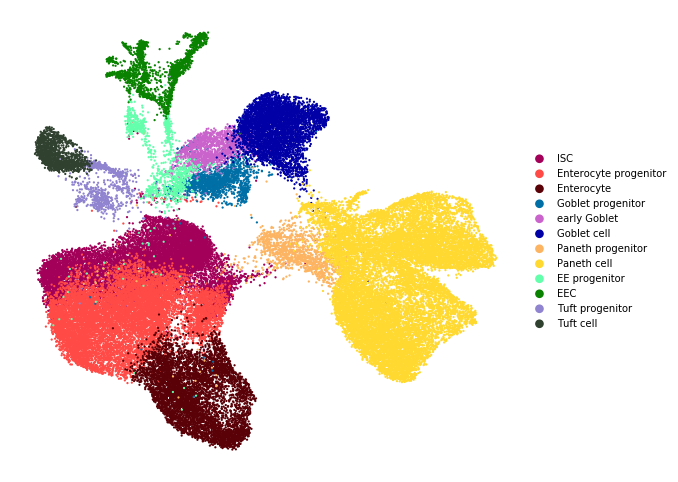

In [20]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(alin, color='proma_cell_type', title='',
           frameon=False, size=20, save=today+'_cell_type_final.pdf')

saving figure to file ./../figures/umap210208_cell_type_final_edges.pdf


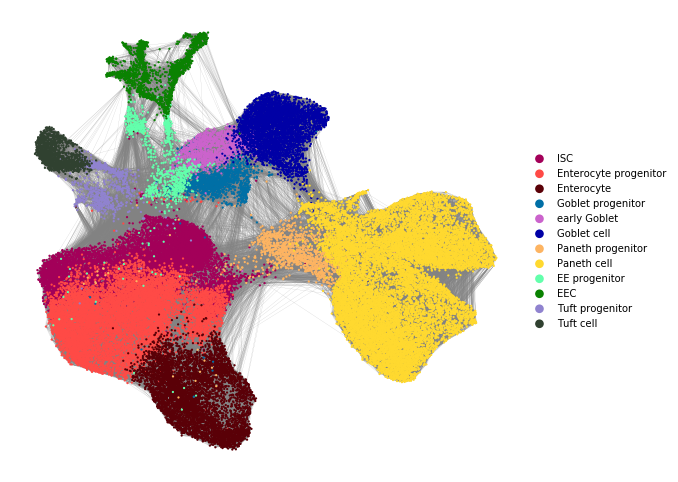

In [21]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(alin, color='proma_cell_type', title='', edges=True,
           frameon=False, size=20, save=today+'_cell_type_final_edges.pdf')

## Correlation plot of all cell types

In [46]:
annot_key='proma_cell_type'

for group in alin.obs[annot_key].cat.categories:
    print(group)
    ix=np.in1d(alin.obs[annot_key],group)
    alin_sub=alin.copy()[ix]
    alin.uns['mean_pca_'+group]=np.squeeze(np.asarray(alin_sub.obsm['X_pca'].mean(axis=0).T))
    del alin_sub

ISC
Enterocyte progenitor
Enterocyte
Goblet progenitor
early Goblet
Goblet cell
Paneth progenitor
Paneth cell
EE progenitor
EEC
Tuft progenitor
Tuft cell


In [50]:
#### create a dataframe  #######

d = {'ISC':alin.uns['mean_pca_ISC'],
     'Enterocyte progenitor':alin.uns['mean_pca_Enterocyte progenitor'],
     'Enterocyte':alin.uns['mean_pca_Enterocyte'],
     'Goblet progenitor':alin.uns['mean_pca_Goblet progenitor'],
     'early Goblet':alin.uns['mean_pca_early Goblet'],
     'Goblet cell':alin.uns['mean_pca_Goblet cell'],
     'EE progenitor':alin.uns['mean_pca_EE progenitor'],
     'EEC':alin.uns['mean_pca_EEC'],
     'Tuft progenitor':alin.uns['mean_pca_Tuft progenitor'],
     'Tuft cell':alin.uns['mean_pca_Tuft cell'],
     'Paneth progenitor':alin.uns['mean_pca_Paneth progenitor'],
     'Paneth cell':alin.uns['mean_pca_Paneth cell']
     }

df = pd.DataFrame(data=d)

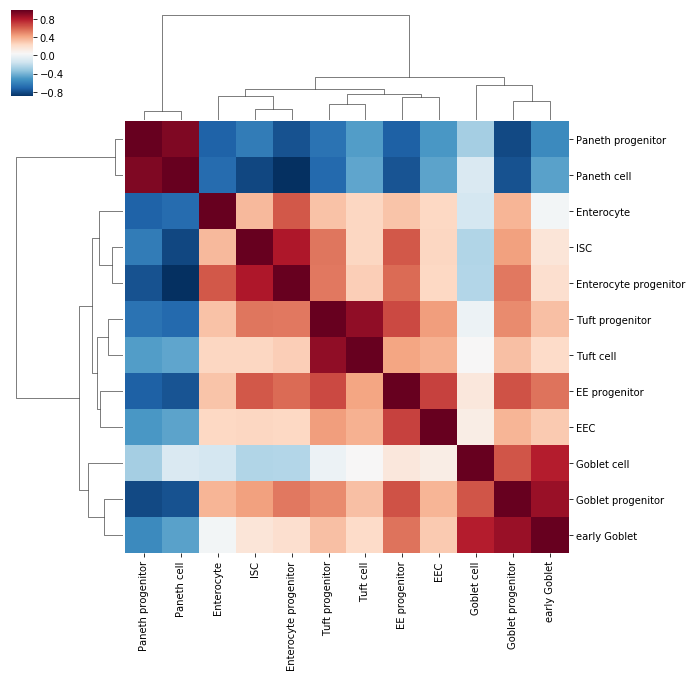

In [51]:
###### calculate correlation  #########

df_cor_pearson=np.corrcoef(df.T)
names=df.columns
df_cor_named_pearson=pd.DataFrame(df_cor_pearson,
                                  index=names,columns=names)


##### clustermap  ######
rcParams['figure.figsize']=(5,5)
ax=sns.clustermap(df_cor_named_pearson,cmap='RdBu_r',method='average')
pl.savefig('./../figures/'+today+'_correlation_progen_Gpc.pdf', 
           dpi=300, orientation='landscape',bbox_inches='tight')

pl.show()


## Compute and display marker genes

Compute marker genes and display the ones for the mature populations (progenitor populations had a less distinct set of markers).

In [52]:
sc.tl.rank_genes_groups(alin,groupby='proma_cell_type', method='wilcoxon')   ##find marker genes


#### extend list of markers with top 50 genes in each group if not already in the list
x=[]
y=[]

for i in ['ISC', 'Enterocyte',  'Goblet cell', 'Paneth cell','EEC', 'Tuft cell']:
    
    group=i
    print(group)

### marker genes above a score of 5 
    ix_score=alin.uns['rank_genes_groups']['scores'][group]>10

       
    try:
        if sum(ix_score)>20:
            x.extend(list(np.sort(alin.uns['rank_genes_groups']['names'][group][ix_score][:19])))
            y.extend(list(alin.uns['rank_genes_groups']['scores'][group][ix_score][:19]))
        else:
            x.extend(list(np.sort(alin.uns['rank_genes_groups']['names'][group][ix_score])))
            y.extend(list(alin.uns['rank_genes_groups']['scores'][group][ix_score]))

       
    except ValueError:
        print ('no significant marker genes..')
        pass
    

from collections import OrderedDict
marker_genes=list(OrderedDict.fromkeys(x))

### create adata_marker (subset with marker genes)

ranking genes
    finished (0:01:50.40) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
ISC
Enterocyte
Goblet cell
Paneth cell
EEC
Tuft cell


In [53]:
marker_genes = np.asarray(marker_genes)[np.invert([genes.startswith('Rp') for genes in marker_genes])]
marker_genes = marker_genes[np.invert([genes.startswith('mt-') for genes in marker_genes])]
marker_genes = marker_genes[np.invert([genes.startswith('Gm') for genes in marker_genes])]

In [54]:
ix=np.isin(alin.raw.var_names,marker_genes)

max_genes =alin.raw.X.max(axis=0).todense()

Scale gene expression to reduce bias towards highly expressed genes. 

In [55]:
X_test = alin.raw.X

In [61]:
alin_plot = ann.AnnData(X= sci.sparse.csr_matrix(X_test), obs=alin.obs, 
                            var=alin.raw.var, uns=alin.uns)

In [66]:
### scale/zero-center adata_marker for visualization
adata_marker_scale=sc.pp.scale(alin_plot,max_value=4,
                               zero_center=False,copy=True)

Split gene names for visualisation.

In [63]:
gene_names = marker_genes

In [64]:
nr_genes = np.ceil(len(gene_names)/2).astype('int')+2
gene_set1 = gene_names[:nr_genes]
gene_set2 = gene_names[nr_genes:]

saving figure to file ./../figures/matrixplot210208_differential_markers_mature_progen20_pt1.pdf


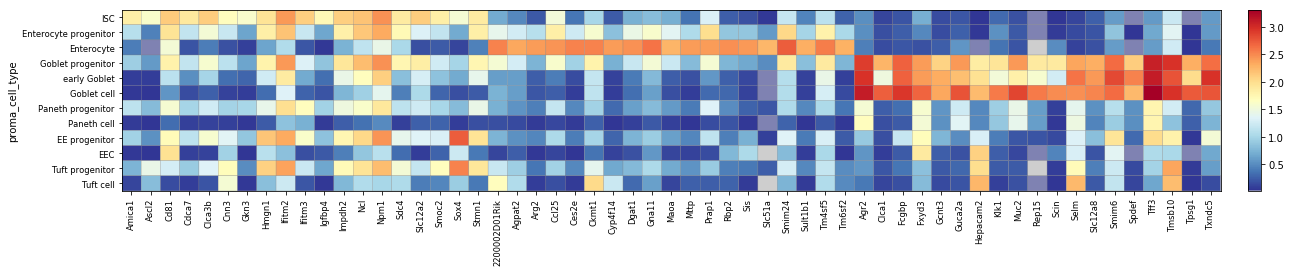

saving figure to file ./../figures/matrixplot210208_differential_markers_mature_progen20_pt2.pdf


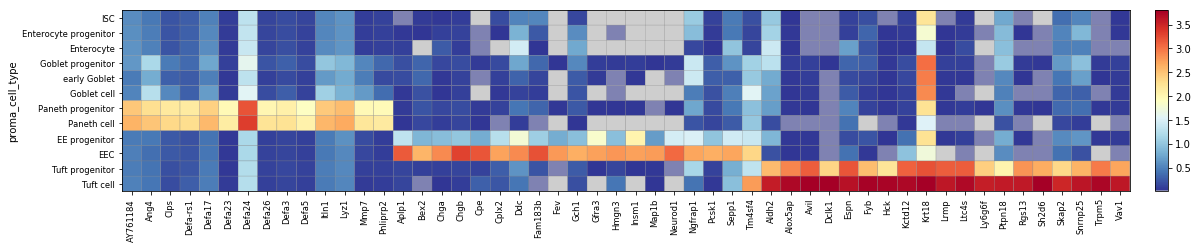

In [68]:
sc.pl.matrixplot(adata_marker_scale, var_group_rotation=True,
                 save=today+ '_differential_markers_mature_progen20_pt1.pdf',
                 groupby='proma_cell_type', var_names=gene_set1, cmap=mymap)
sc.pl.matrixplot(adata_marker_scale, var_group_rotation=True, 
                 save=today+ '_differential_markers_mature_progen20_pt2.pdf',
                 groupby='proma_cell_type', var_names=gene_set2, cmap=mymap)

## Display known markers and transcription factors

We previously tested ISCs and the progenitor populations pairwise for differentially expressed genes with limma. From this list, we extracted all differentially expressed transcription factors.

In [155]:
tfs = pd.read_csv('./../table/TFs_progenitors_2021.csv',
                  index_col=0, header=None, skiprows=1).index

In [156]:
tfs

Index(['2010315B03Rik', '2610044O15Rik8', 'Aebp2', 'Ahr', 'AI987944', 'Arap1',
       'Arnt', 'Arntl', 'Ascl2', 'Atf1',
       ...
       'Zfp961', 'Zfpm1', 'Zgpat', 'Zhx1', 'Zkscan1', 'Zkscan14', 'Zkscan17',
       'Zscan21', 'Zscan26', 'Zscan29'],
      dtype='object', name=0, length=413)

* Ybx1: Y-box binding protein, cancer drug target
* Hes6: antagonist of Hes1
* Prox1: TF involved in cell fate determination
* Klf3: play a role in hematopoiesis 
* Tcf4: initiation of neuronal differentiation
* Atoh8: modulates the differentiation program initiated by the pro-endocrine factor NEUROG3
* Ehf: role in regulating epithelial cell differentiation and proliferation
* Pou2f3: plays a critical role in keratinocyte proliferation and differentiation
* Spib: can act as a lymphoid-specific enhancer
* Runx1: RUNX1 is a transcription factor that forms a complex with the cofactor CBFB, known in hematopoietic lineages

In [170]:
new_tfs = ['Ybx1', #
           'Creb3l1',
           'Creb3l2',
           'Creb3l4',
            'Hes6',
           'Foxa3',
           
             'Klf3','Atoh1','Spdef', #Goblet pro
           'Tcf4',
           'Ehf' ,
           'Klf15', #Paneth pro
           'Sox4', #Ngn3 pro
            'Pou2f3', 'Spib', 'Runx1', #Tuft pro 
          ]

In addition to the new transcription factors, we display known markers and cell cycle genes.

In [157]:
genes_io_progen = ['Ascl2', 'Notch1', 'Hes1',  'Dll1', 'Dll4', 'Gfi1',
                   'Neurod1', 'Foxa1', 'Foxa2', 'Elf3',  
                   'Sox9',  'Tead2', 'Yap1', #known decision makers
                  
]
cell_cycle_genes =[
            'Mki67', 'Ccnd1', 'Cdk1', 'Aurkb', #proliferation
            'Cdkn1a', 'Cdkn2d' #cell cycle exit
           ]

In [158]:
adata_idx = np.in1d(alin.obs['refined_clustering'], 
                    ['ISC','Paneth primed ISC', 'Enterocyte progenitor',
                     'Sox4+ early EE progenitor',#'early Goblet', 
                     'Goblet progenitor',
                     'Ngn3 progenitor',
                    'Paneth progenitor','Tuft progenitor'])
adata = alin[adata_idx]
adata.obs['progenitors'] = adata.obs['refined_clustering']

#subsample ISCs and Enterocyte progenitors for display
#idx_ISC_EC =np.flatnonzero(np.in1d(adata.obs['progenitors'], 
#                                   ['ISC', 'Enterocyte progenitor']))
#subset = np.random.choice(idx_ISC_EC,replace=False, 
#                          size=np.floor(0.3*adata.X.shape[0]).astype('int'))


#new_index = np.concatenate([subset, 
#          np.flatnonzero(np.invert(np.in1d(alin.obs['progenitors'], 
#                                    ['ISC', 'Enterocyte progenitor'])))])
#adata_plot = ann.AnnData(X=adata[new_index].raw.X, 
#obs=adata[new_index].obs, var=adata.raw.var, 
#                             uns=adata.uns
#                            )

adata_plot = ann.AnnData(X=adata.raw.X, 
                             obs=adata.obs, 
                             var=adata.raw.var, 
                             uns=adata.uns
                            )
adata_plot.X 
sc.pp.scale(adata_plot, max_value=4, zero_center=False)

/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1116: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(var)
/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1119: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


In [171]:
genes_diff_idx = np.in1d(adata_plot.var_names, new_tfs)

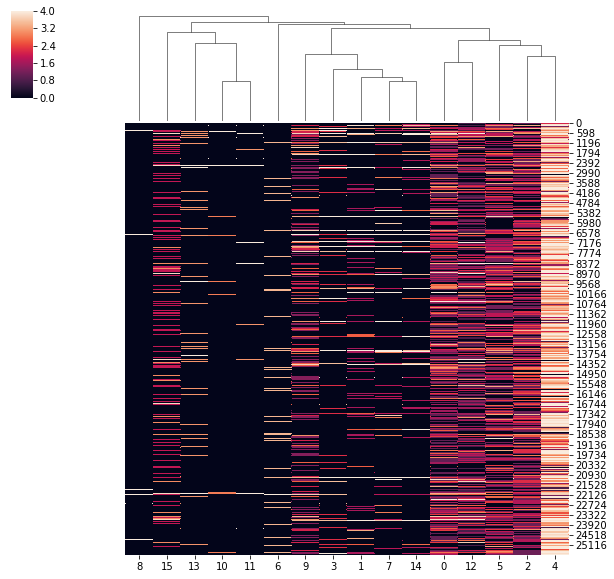

In [172]:
g=sns.clustermap(adata_plot.X[:,genes_diff_idx].todense(),
                 row_cluster=False,metric='correlation')
gene_names_diff=adata_plot[:,genes_diff_idx].var_names[g.dendrogram_col.reordered_ind]

saving figure to file ./../figures/matrixplot210208_diff_knownTFs_ISC_progen_unsorted.pdf


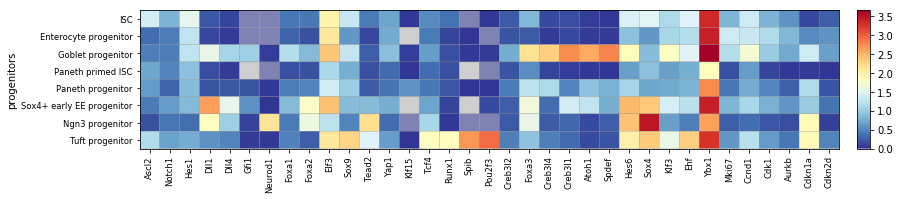

In [173]:
sc.pl.matrixplot(adata_plot, 
                 var_names=np.concatenate([genes_io_progen,
                                           gene_names_diff, cell_cycle_genes]), 
                 groupby='progenitors', cmap=mymap,
                 save=today + '_diff_knownTFs_ISC_progen_unsorted.pdf'
                )

## Display receptor expression

Here we plot receptor genes of interest in the progenitor populations.

In [210]:
receptors = ['Fgfr1','Fgfr2','Fgfr3','Fgfr4', #FGF
    'Egfr', 'Erbb2','Erbb3','Lrig1', #EGF 
    'Bmpr1a', 'Bmpr2','Id1','Id2','Id3', #BMP
    'Notch1','Notch2','Notch3','Jag1','Dll1','Dll4','Hes1','Lfng', #Notch 
    'Sfrp5','Sfrp1','Fzd1','Fzd2','Fzd3','Fzd6','Fzd7','Fzd8','Lrp5','Lrp6', #Wnt 
    'Smo', 'Shh', 'Ihh', #Hedgehog
    'Yap1','Tead2', 'Tead3', #Hippo
    'Fzd3', 'Fzd6', 'Ror2', 'Ptk7', 
    'Celsr1', 'Vangl1', 'Vangl2', 'Prickle1', 'Jun', #Wnt/PCP
    'Ephb2', 'Ephb3', 'Efnb1', #Ephrin signalling
    'Itgb1', 'Itga1','Itga2', 'Itga3', 
             'Itga5', 'Itga6', 'Itga9' #integrin signalling
]

In [216]:
valid_rec = [receptor for receptor in receptors if 
       np.in1d(receptor,  adata.raw.var_names)]

saving figure to file ./../figures/dotplot210208_diff_receptors_ISC_progen.pdf


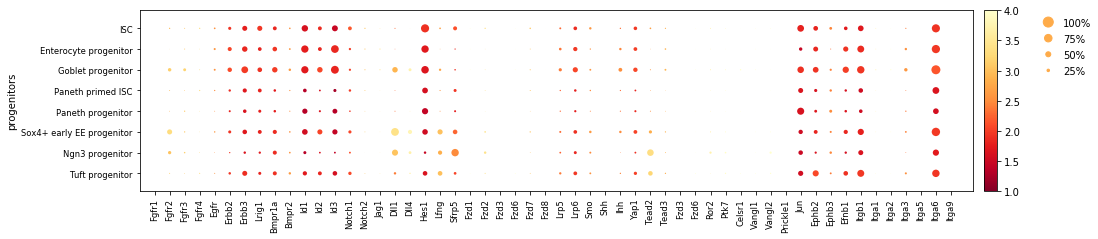

In [223]:
dotplot(adata_plot,  
        var_names=valid_rec, 
        
        max_scale=4, min_scale=1,
        groupby='progenitors', color_map='YlOrRd_r', #cmap=mymap,
        save=today + '_diff_receptors_ISC_progen.pdf'
                )

# Graph abstraction

Compute graph abstraction for progenitor and mature cell types.

In [28]:
sc.tl.paga(alin, groups='proma_cell_type')

running partition-based graph abstraction (PAGA)
    finished (0:00:04.67) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


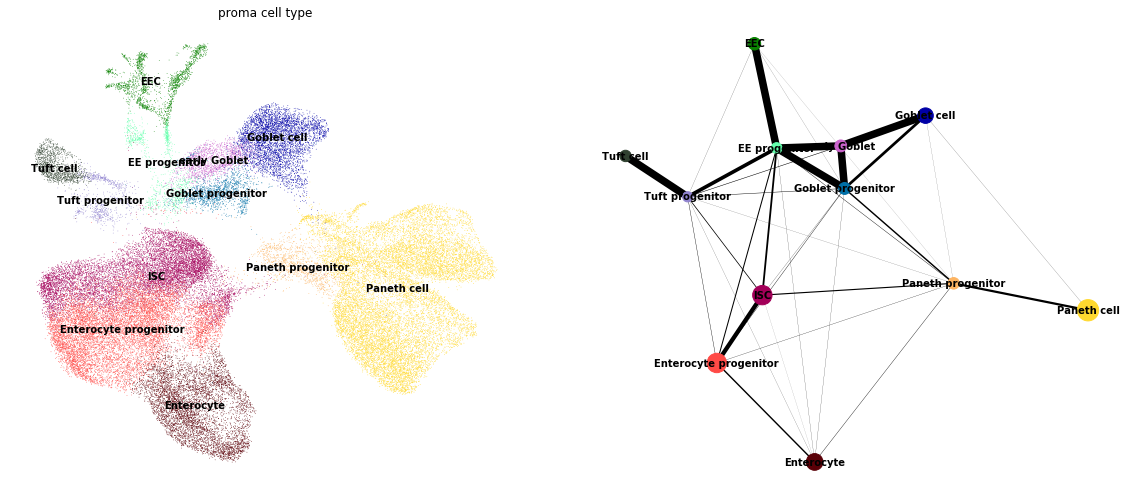

In [29]:
sc.pl.paga_compare(alin, basis='umap', frameon=False, show=True)

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./../figures/paga210208_cell_type_final_005.pdf


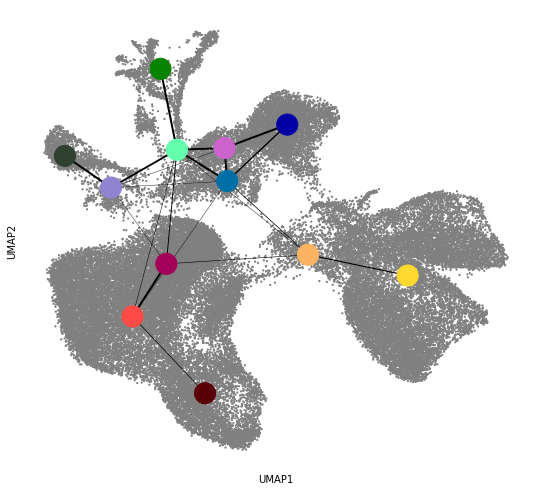

In [31]:
asso_names = ['','','','',
              '','','','',
              '','','','' 
              ]

ax = sc.pl.umap(alin, color='grey', size=20, show=False)
sc.pl.paga(alin, 
           pos=alin.uns['paga']['pos'], labels=asso_names,
           node_size_power=0, node_size_scale=3,
           edge_width_scale=0.5, frameon=False,
           threshold=0.05,min_edge_width=0.4,max_edge_width=2, 
           save=today+'_cell_type_final_005.pdf', ax=ax
               )

# Elucidate ISC - Paneth cell lineage

UMAP with ISC - PC lineage highlighted.

In [32]:
alin.obs['ISC_PC_highlight'] = alin.obs['refined_clustering']
alin.obs['ISC_PC_highlight'] = alin.obs['ISC_PC_highlight'].cat.add_categories('other')
other_idx = np.in1d(alin.obs['ISC_PC_highlight'], 
            ['Enterocyte', 'Enterocyte progenitor', 'Goblet progenitor',
       'early Goblet', 'Goblet cell',  'Lgr5+ EEC',
       'Sox4+ early EE progenitor', 'Ngn3 progenitor', 'Isl1/Arx progenitor',
       'Pax4 progenitor', 'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA',
       'SIK', 'SIL-P', 'SILA', 'SIN', 'Tuft progenitor', 'Tuft 1', 'Tuft 2'])
alin.obs['ISC_PC_highlight'][other_idx] = np.repeat('other', other_idx.sum())

In [33]:
other_idx

array([False, False,  True, ..., False,  True,  True])

In [34]:
alin.obs['ISC_PC_highlight'].cat.categories

Index(['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor',
       'early Goblet', 'Goblet cell', 'Paneth primed ISC', 'Paneth progenitor',
       'Paneth 1', 'Paneth 2', 'Lgr5+ EEC', 'Sox4+ early EE progenitor',
       'Ngn3 progenitor', 'Isl1/Arx progenitor', 'Pax4 progenitor',
       'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA', 'SIK', 'SIL-P',
       'SILA', 'SIN', 'Tuft progenitor', 'Tuft 1', 'Tuft 2', 'other'],
      dtype='object')

In [35]:
alin.obs['ISC_PC_highlight'] = alin.obs['ISC_PC_highlight'].cat.remove_unused_categories()
alin.obs['ISC_PC_highlight'] = alin.obs['ISC_PC_highlight'].cat.reorder_categories(['ISC', 
       'Paneth primed ISC', 'Paneth progenitor', 'Paneth 1', 'Paneth 2','other'
       ])

In [36]:
alin.uns['ISC_PC_highlight_colors'] = list()
alin.uns['ISC_PC_highlight_colors'].append('#A30059') #ISC
alin.uns['ISC_PC_highlight_colors'].append('#253756') #Paneth primed ISC
alin.uns['ISC_PC_highlight_colors'].append('#fdb462') #Paneth progenitor
alin.uns['ISC_PC_highlight_colors'].append('#ffd92f') #Paneth 1
alin.uns['ISC_PC_highlight_colors'].append('#BA656C') #Paneth 2
alin.uns['ISC_PC_highlight_colors'].append('#808080') #other


In [37]:
alin.obs['ISC_PC_highlight'].cat.categories

Index(['ISC', 'Paneth primed ISC', 'Paneth progenitor', 'Paneth 1', 'Paneth 2',
       'other'],
      dtype='object')

In [38]:
pd.DataFrame(alin.uns['ISC_PC_highlight_colors'], alin.obs['ISC_PC_highlight'].cat.categories)

,0
ISC,#A30059
Paneth primed ISC,#253756
Paneth progenitor,#fdb462
Paneth 1,#ffd92f
Paneth 2,#BA656C
other,#808080


saving figure to file ./../figures/umap210208_ISC_PC_highlighted.pdf


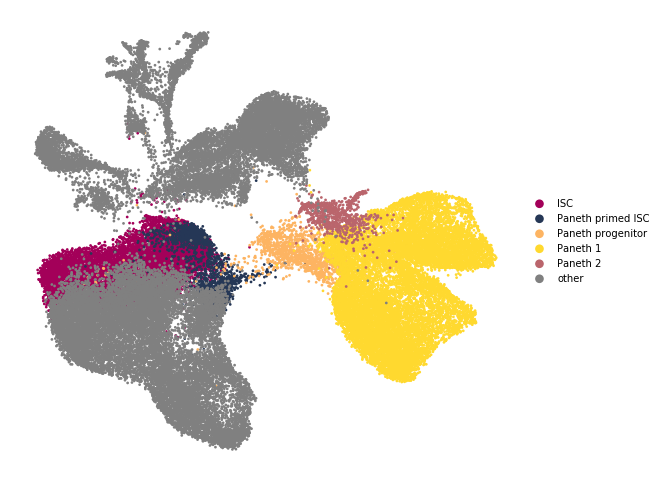

In [39]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(alin, color='ISC_PC_highlight', size=30, 
           frameon=False, title='', save= today + '_ISC_PC_highlighted.pdf')

saving figure to file ./../figures/dotplot210208_ISC_PC_direction.pdf


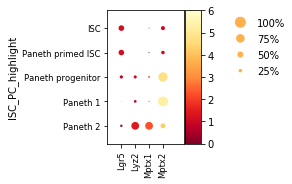

In [40]:
rcParams['figure.figsize']=(5,5)
dotplot(alin[np.invert(alin.obs['ISC_PC_highlight']=='other'),], 
        color_map='YlOrRd_r',
        save=today+'_ISC_PC_direction.pdf', 
        max_scale=6,
        min_scale=0,
        groupby='ISC_PC_highlight', 
        var_names=['Lgr5','Lyz2', 'Mptx1', 'Mptx2'])


## Plot scores along dpt

In [44]:
sc.tl.paga(alin, groups='ISC_PC_highlight')

running partition-based graph abstraction (PAGA)
    finished (0:00:03.53) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


saving figure to file ./../figures/paga_path210208_Paneth_scores.pdf


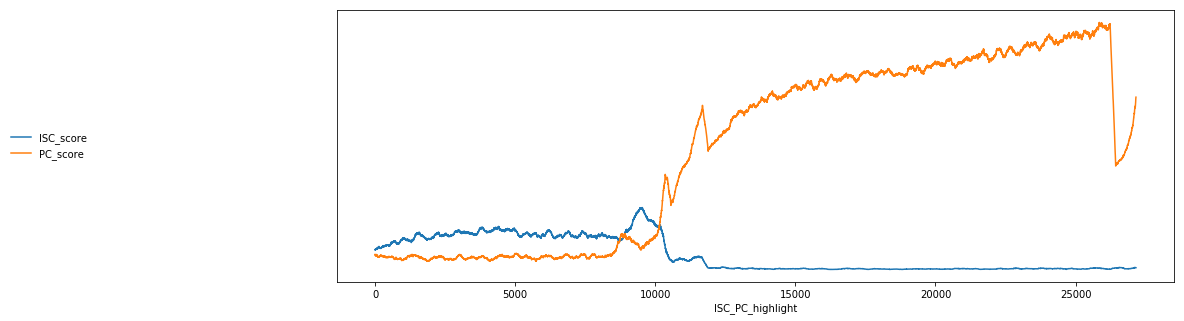

In [45]:
rcParams['figure.figsize']=(15,5)
sc.pl.paga_path(alin, as_heatmap=False, keys=['ISC_score', 'PC_score'], 
                annotations=[], 
                nodes=[ 'ISC', 'Paneth primed ISC', 
                       'Paneth progenitor', 'Paneth 1', 'Paneth 2'], n_avg=200, 
                save=today+'_Paneth_scores.pdf'
               )

## Heatmap for differential gene expression

Compute pseudotime.

In [69]:
sc.pp.neighbors(alin, n_neighbors=30)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:37.22) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [70]:
mki67_idx=np.in1d(alin.var_names, 'Mki67')

In [71]:
alin.uns['iroot']=np.flatnonzero((alin.X[:,mki67_idx]>800).todense())[1]
sc.tl.diffmap(alin)
sc.tl.dpt(alin)

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9988525  0.9967907  0.99641937 0.99572927 0.9924359
     0.98762804 0.9846585  0.9801306  0.98001105 0.9794232  0.9782921
     0.97448164 0.9726831  0.97176474]
    finished (0:00:06.54) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.01) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:856: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(row)


Load limma results for Paneth maturation. Please note that we summarised all limma results after pairwise testing.

In [76]:
limma_PC = pd.read_csv('./../table/limma_results_210209_controls_PC_maturation.csv', 
                       index_col=0)

In [77]:
pd.crosstab(limma_PC['cell_type1'], limma_PC['cell_type2'])

cell_type2,ISC,Paneth 1,Paneth primed ISC,Paneth progenitor
cell_type1,,,,
Paneth 1,6484,0,3173,4535
Paneth 2,7249,4407,4345,6292
Paneth primed ISC,7615,0,0,0
Paneth progenitor,3488,0,6943,0


Get genes high in ISCs:

In [140]:
genes_high_ISC= limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type2']=='ISC'),
                                        limma_PC['logFC']<-2)].sort_values(by='logFC', ascending=True).index
genes_high_ISC = genes_high_ISC[np.invert([genes.startswith('Rp') for genes in genes_high_ISC])]
genes_high_ISC = genes_high_ISC[np.invert([genes.startswith('mt-') for genes in genes_high_ISC])]
genes_high_ISC = genes_high_ISC[np.invert([genes.startswith('Gm') for genes in genes_high_ISC])]

In [141]:
genes_high_ISC

Index(['Hsp90ab1', 'Npm1', 'Hspa8', 'Actg1', 'Ptma', 'Tmsb4x', 'Ncl', 'Stmn1',
       'Clca3b', 'Stmn1', 'Clca3b'],
      dtype='object', name='X')

Get genes high in Paneth primed ISCs:

In [142]:
genes_high_PISC1 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                limma_PC['cell_type2']=='Paneth primed ISC'),
                        limma_PC['logFC']<-1)].sort_values(by='logFC', ascending=True).index
genes_high_PISC2 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type1']=='Paneth primed ISC'),
                                        limma_PC['logFC']>1)].sort_values(by='logFC', ascending=True).index
#get genes high in Paneth primed ISC vs ISC
genes_high_PISC3 = limma_PC[np.logical_and(np.logical_and(limma_PC['cell_type2']=='ISC', 
                                                       limma_PC['cell_type1']=='Paneth primed ISC'),
                                        limma_PC['logFC']>0.1)].sort_values(by='logFC', ascending=True).index
#genes high in ISC compared to Paneth primed ISC
genes_high_PISC4 = limma_PC[np.logical_and(np.logical_and(limma_PC['cell_type2']=='ISC', 
                                                       limma_PC['cell_type1']=='Paneth primed ISC'),
                                        limma_PC['logFC']<-1)].sort_values(by='logFC', ascending=True).index
genes_high_PISC = np.concatenate([genes_high_PISC1, genes_high_PISC2, genes_high_PISC3])
genes_high_PISC = genes_high_PISC[np.invert([genes.startswith('Rp') for genes in genes_high_PISC])]
genes_high_PISC = genes_high_PISC[np.invert([genes.startswith('mt-') for genes in genes_high_PISC])]
genes_high_PISC = genes_high_PISC[np.invert([genes.startswith('Gm') for genes in genes_high_PISC])]

Get genes high in Paneth progenitor:

In [143]:
genes_high_Ppc1 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type2']=='Paneth progenitor'),
                                        limma_PC['logFC']<-2)].sort_values(by='logFC', ascending=True).index
genes_high_Ppc2 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type1']=='Paneth progenitor'),
                                        limma_PC['logFC']>2)].sort_values(by='logFC', ascending=True).index
genes_high_Ppc = np.concatenate([genes_high_Ppc1, genes_high_Ppc2])
genes_high_Ppc = genes_high_Ppc[np.invert([genes.startswith('Rp') for genes in genes_high_Ppc])]
genes_high_Ppc = genes_high_Ppc[np.invert([genes.startswith('mt-') for genes in genes_high_Ppc])]
genes_high_Ppc = genes_high_Ppc[np.invert([genes.startswith('Gm') for genes in genes_high_Ppc])]

Get genes high in Paneth 1:

In [144]:
genes_high_PC1 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type2']=='Paneth 1'),
                                        limma_PC['logFC']<-3)].sort_values(by='logFC', ascending=True).index
genes_high_PC2 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type1']=='Paneth 1'),
                                        limma_PC['logFC']>3)].sort_values(by='logFC', ascending=True).index
genes_high_Pan1 = np.concatenate([genes_high_PC1, genes_high_PC2])
genes_high_Pan1 = genes_high_Pan1[np.invert([genes.startswith('Rp') for genes in genes_high_Pan1])]
genes_high_Pan1 = genes_high_Pan1[np.invert([genes.startswith('mt-') for genes in genes_high_Pan1])]
genes_high_Pan1 = genes_high_Pan1[np.invert([genes.startswith('Gm') for genes in genes_high_Pan1])]

Get genes high in Paneth 2:

In [145]:
genes_high_PC1 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type2']=='Paneth 2'),
                                        limma_PC['logFC']<-3)].sort_values(by='logFC', ascending=True).index
genes_high_PC2 = limma_PC[np.logical_and(np.logical_and(limma_PC['adj.P.Val']==0, 
                                                       limma_PC['cell_type1']=='Paneth 2'),
                                        limma_PC['logFC']>3)].sort_values(by='logFC', ascending=True).index
genes_high_Pan2 = np.concatenate([genes_high_PC1, genes_high_PC2])
genes_high_Pan2 = genes_high_Pan2[np.invert([genes.startswith('Rp') for genes in genes_high_Pan2])]
genes_high_Pan2 = genes_high_Pan2[np.invert([genes.startswith('mt-') for genes in genes_high_Pan2])]
genes_high_Pan2 = genes_high_Pan2[np.invert([genes.startswith('Gm') for genes in genes_high_Pan2])]

In [146]:
genes_list =np.concatenate([genes_high_ISC, genes_high_PISC, 
                genes_high_Ppc, genes_high_Pan1, genes_high_Pan2])

from collections import OrderedDict
marker_genes3=list(OrderedDict.fromkeys(genes_list))

In [147]:
len(marker_genes3)

44

In [148]:
adata_plot = alin[np.in1d(alin.obs['ISC_PC_highlight'],
                          alin.obs['ISC_PC_highlight'].cat.categories[:-1])]
adata_plot.obs['ISC_PC_highlight'] = adata_plot.obs['ISC_PC_highlight'].cat.remove_unused_categories()

In [149]:
sc.tl.paga(adata_plot, groups='ISC_PC_highlight')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.56) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


In [150]:
#genes_diff = np.concatenate([marker_genes, marker_genes2, genes_PC_1_2])
genes_diff_idx = np.in1d(alin.raw.var_names, marker_genes3)

Group genes by similarity through hierarchical clustering.

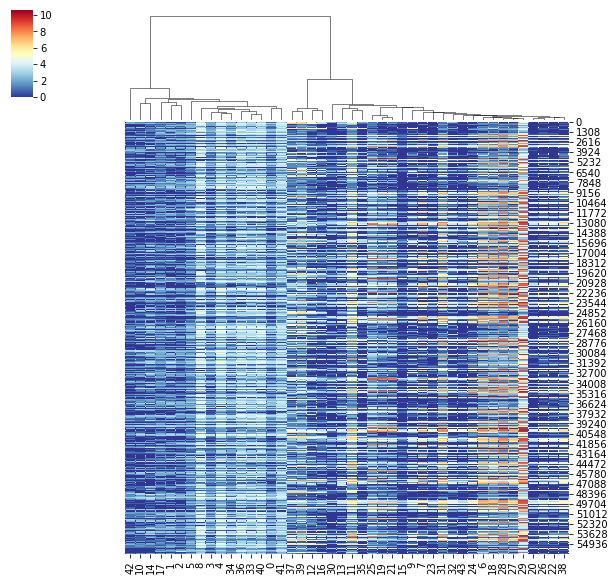

In [151]:
g=sns.clustermap(alin.raw.X[:,genes_diff_idx].todense(),
                 cmap="RdYlBu_r",row_cluster=False,metric='correlation')

In [152]:
gene_names_diff=alin.raw[:,genes_diff_idx].var_names[g.dendrogram_col.reordered_ind]

saving figure to file ./../figures/paga_path210208_ISC_PC_dpt.pdf


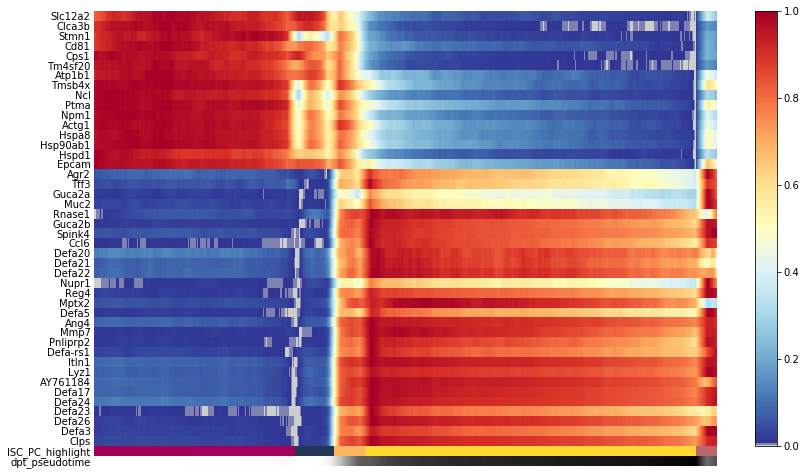

In [153]:
rcParams['figure.figsize']=(18,8)
sc.pl.paga_path(adata_plot, left_margin=0.3, 
                #nodes=adata_plot.obs['ISC_PC_highlight'].cat.categories,
                nodes=[ 'ISC', 'Paneth primed ISC',
                       'Paneth progenitor','Paneth 1', 'Paneth 2' 
                  ],
                ytick_fontsize=10, color_map=mymap, 
                keys=gene_names_diff,
                normalize_to_zero_one=True,
                annotations=['dpt_pseudotime'],
                #show_yticks=True if ipath==0 else False,
                #show_colorbar=True if ipath==2 else False,                       
                n_avg=500, 
                show_node_names=False,
                save=today+'_ISC_PC_dpt.pdf',
                   #title='{}'.format(descr),
                show=True)